### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, f1_score

import tensorflow as tf
from keras import Sequential, regularizers
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras_tuner import HyperModel, Hyperband

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  0


### Load Datasets & Data Preprocessing

#### Description of features
- **WDIR**: Wind direction
- **WSPD**: Wind speed
- **WSPD_T**: Transformed wind speed
- **rWSPD**: Lagged wind speed
- **rWSPD_T**: Transformed lagged wind speed (for sikorsky)
- **Fetch**: Fetch distance

#### Description of target
- **SWHft**: Significant wave height (in feet)

In [3]:
spike = 2       # Spike threshold
WSPD = 'WSPD_T' # {'WSPD','WSPD_T'}

df_buoy_04_13 = pd.read_csv('Data_Buoy_2004_2013.csv')
df_stn_04_13 = pd.read_csv('Data_Sikorsky_2004_2013.csv')
df_stn_04_13['WSPD_T'] = df_stn_04_13['rWSPD_T'].shift(-1).ffill()

df1 = pd.concat([df_buoy_04_13[['TimeStamp_1','SWHft']], df_stn_04_13[[WSPD,'Fetch']]], axis=1)
df1['Spike'] = (df1['SWHft'] > spike).astype(int)

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)

# Train-Test split
seperate_date = pd.to_datetime('2005-10-31 23:59:00')
df_train = df1[df1.index > seperate_date]  # From 2005-11-01 00:00:00 to 2013-10-31 23:00:00
df_test = df1[df1.index < seperate_date]   # From 2004-11-01 00:00:00 to 2005-10-31 23:00:00

# Data normalization
scaler_wind = MinMaxScaler()

df_train = df_train.copy()
df_test = df_test.copy()

# Normalize WSPD and fetch in both datasets
df_train.loc[:, ['scaled_WSPD', 'scaled_Fetch']] = scaler_wind.fit_transform(df_train[[WSPD, 'Fetch']])
df_test.loc[:, ['scaled_WSPD', 'scaled_Fetch']] = scaler_wind.transform(df_test[[WSPD, 'Fetch']])

df_train.head()

,SWHft,WSPD_T,Fetch,Spike,scaled_WSPD,scaled_Fetch
TimeStamp_1,,,,,,
2005-11-01 00:00:00,1.640420,6.56483,16093.4,0,0.274244,0.042553
2005-11-01 01:00:00,1.968504,4.62640,16093.4,0,0.171038,0.042553
2005-11-01 02:00:00,1.968504,4.94865,16093.4,0,0.188195,0.042553
2005-11-01 03:00:00,1.640420,4.62640,16093.4,0,0.171038,0.042553
2005-11-01 04:00:00,1.312336,5.77390,16093.4,0,0.232133,0.042553


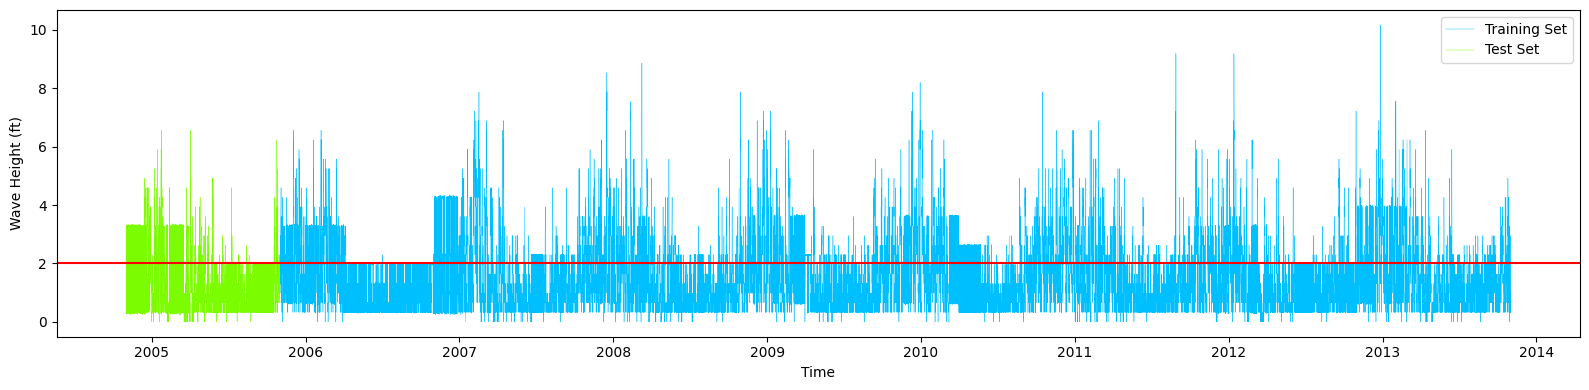

In [4]:
# Training and test data visualization
plt.figure(figsize=(16, 4))
plt.plot(df_train['SWHft'], linewidth=0.3, color='deepskyblue', label='Training Set')
plt.plot(df_test['SWHft'], linewidth=0.3, color='lawngreen', label='Test Set')
plt.axhline(y=spike, color='r')

plt.xlabel('Time')
plt.ylabel('Wave Height (ft)')
plt.legend()

plt.tight_layout()
plt.show()

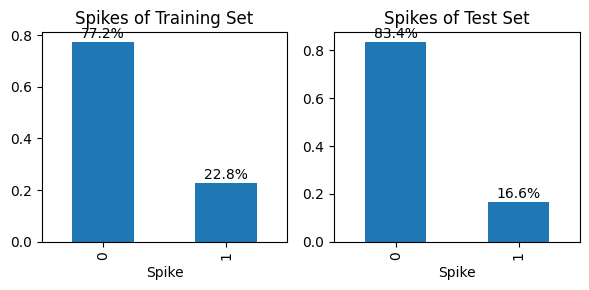

In [5]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
train_counts = df_train['Spike'].value_counts(normalize=True)
train_counts.plot(kind='bar')
plt.title('Spikes of Training Set')

for i, v in enumerate(train_counts):
    plt.text(i, v+0.005, f'{v:.1%}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
test_counts = df_test['Spike'].value_counts(normalize=True)
test_counts.plot(kind='bar')
plt.title('Spikes of Test Set')

for i, v in enumerate(test_counts):
    plt.text(i, v+0.005, f'{v:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Data Preparation: Train-Test-Validation Split

In [6]:
time_step = 12  # Use the previous time steps data to predict the next wave height
features = ['Spike', 'scaled_WSPD', 'scaled_Fetch']

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step):
        # X.append(data[i:(i+time_step), 1:])   # Past hours (WSPD, fetch)
        X.append(data[i:(i+time_step+1), 1:]) # (Past + current) hours (WSPD, fetch)
        y.append(data[i+time_step, 0])        # Next hour wave height
    return np.array(X), np.array(y)

# Training set: 2006-11-01 00:00:00 to 2013-10-31 23:00:00
# Validation set: 2005-11-01 00:00:00 to 2006-10-31 23:00:00
seperate_date = pd.to_datetime('2006-10-31 23:59:00')
df_split1 = df_train[df_train.index > seperate_date]
df_split2 = df_train[df_train.index < seperate_date]

X_train, y_train = create_sequences(df_split1[features].values, time_step)
X_val, y_val = create_sequences(df_split2[features].values, time_step)
X_test, y_test = create_sequences(df_test[features].values, time_step)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(61356, 13, 2)
(8748, 13, 2)
(8748, 13, 2)


### Model Selection and Implementation

Epoch 1/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.6716 - loss: 0.8052 - val_AUC: 0.8662 - val_loss: 0.4828
Epoch 2/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7895 - loss: 0.5637 - val_AUC: 0.8823 - val_loss: 0.4164
Epoch 3/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7983 - loss: 0.5498 - val_AUC: 0.8820 - val_loss: 0.4229
Epoch 4/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8027 - loss: 0.5443 - val_AUC: 0.8896 - val_loss: 0.4632
Epoch 5/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8025 - loss: 0.5436 - val_AUC: 0.8888 - val_loss: 0.4110
Epoch 6/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8067 - loss: 0.5378 - val_AUC: 0.8836 - val_loss: 0.3650
Epoch 7/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8019 - loss: 0.5411 - val_AUC: 0.8919 - val_loss: 0.4118
Epoch 8/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8051 - loss: 0.5379 - val_AUC: 0.8911 - val_loss: 0.4269
Epoch 9/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AU

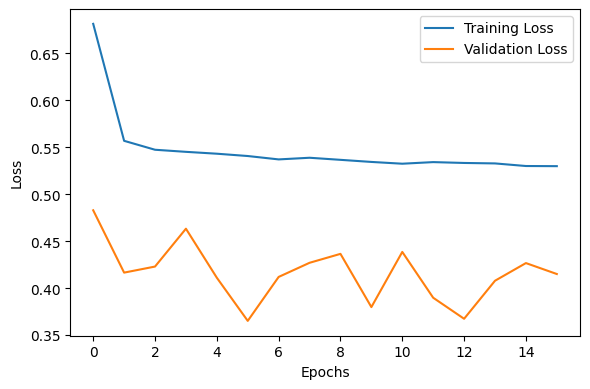

In [7]:
epochs = 50
batch_size = 128
model_file = 'model_2.keras'

# Model architecture
def create_model(X_train):
    model = Sequential([
        # Input layer with shape: (samples, time_steps, features)
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        
        # LSTM layers
        LSTM(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01), dropout=0.2, return_sequences=True),
        LSTM(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01), dropout=0.2, return_sequences=False),
        
        # Output layer
        Dense(1, activation='sigmoid'),
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])
    
    return model

# Class weights computation
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i:class_weights[i] for i in range(len(class_weights))}

# Train and save the model (architecture + weights)
model = create_model(X_train)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es], class_weight=class_weights_dict)
model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Hyperparameters Tuning

#### Hyperparameters selection
- **Time steps**: 12, 24
- **Batch size**: 64, 128, 256
- **# of LSTM layers**: 1, 2, 3
- **# of LSTM units**: 16, 32, 64
- **Dropout rate**: 0.2, 0.5
- **Activation**: 'relu', 'tanh' (might work better for LSTM layers)
- **Learning rate**: logarithmic sampling of $10^{-4}$ ~ $10^{-2}$

#### Tools
- **Grid/Random search (KerasRegressor)**
- **Optuna/Hyperopt**
- **KerasTuner**

In [ ]:
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        
        # Input layer with shape: (samples, time_steps, features)
        model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
        
        # Tunable LSTM layers and units
        num_layers = hp.Int('layers', min_value=1, max_value=3, step=1)
        for i in range(num_layers):
            model.add(LSTM(
                hp.Choice(f'units_{i}', values=[16, 32, 64]),
                activation = hp.Choice(f'activation_{i}', values=['tanh']),
                kernel_regularizer = regularizers.l2(0.01),
                dropout = hp.Choice(f'dropout_{i}', values=[0.2, 0.5]),
                return_sequences = True if i < num_layers-1 else False))
        
        # Output layer
        model.add(Dense(1))
        
        # Compile the model
        model.compile(
            optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
            loss = 'mse',
            metrics=['mse'],
        )
        
        return model

# Search space setup
tuner = Hyperband(
    LSTMHyperModel(),
    objective = 'val_loss',
    max_epochs = 30,
    factor = 3,
    directory = 'hp_tuning',
    project_name = 'lstm_tuning'
)

# Hyperparameter tuning
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])

In [ ]:
# Best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

# Best model
best_model = tuner.get_best_models(1)[0]
print(best_model.summary())

In [ ]:
model_file = 'best_model.keras'

# Train and save the model (architecture + weights)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])
best_model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation

In [8]:
# Load the saved model
model = load_model(model_file)

y_pred1 = model.predict(X_train, verbose=0) # Training error
y_pred2 = model.predict(X_val, verbose=0)   # Validation error
y_pred3 = model.predict(X_test, verbose=0)  # Test error

In [9]:
threshold = 0.3  # Define the threshold

# Training error
y_pred1 = (y_pred1 >= threshold).astype(int)
recall1 = recall_score(df_split1['Spike'][time_step:], y_pred1)
f1_1 = f1_score(df_split1['Spike'][time_step:], y_pred1)
print(f'Training Recall: {recall1:.3f}')
print(f'Training F1: {f1_1:.3f}')

# Validation error
y_pred2 = (y_pred2 >= threshold).astype(int)
recall2 = recall_score(df_split2['Spike'][time_step:], y_pred2)
f1_2 = f1_score(df_split2['Spike'][time_step:], y_pred2)
print(f'Validation Recall: {recall2:.3f}')
print(f'Validation F1: {f1_2:.3f}')

# Test error
y_pred3 = (y_pred3 >= threshold).astype(int)
recall3 = recall_score(df_test['Spike'][time_step:], y_pred3)
f1_3 = f1_score(df_test['Spike'][time_step:], y_pred3)
print(f'Test Recall: {recall3:.3f}')
print(f'Test F1: {f1_3:.3f}')

Training Recall: 0.724
Training F1: 0.584
Validation Recall: 0.862
Validation F1: 0.566
Test Recall: 0.723
Test F1: 0.457
